# Importing packages

In [1]:
#install.packages("here")
library(here, help, pos = 2, lib.loc = NULL)
source(here('Modules','modules.R'))
source(here('Modules','data_cleaning.R'))


Warning message:
"package 'here' was built under R version 4.1.1"
here() starts at C:/Users/maria/Desktop/Programacao/IC/projetos/Barreiras-e-Facilitadores

Warning message:
"package 'ggplot2' was built under R version 4.1.1"
Warning message:
"package 'cowplot' was built under R version 4.1.1"
Warning message:
"package 'randomForest' was built under R version 4.1.1"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


Warning message:
"package 'caret' was built under R version 4.1.1"
Carregando pacotes exigidos: lattice

Warning message:
"package 'lattice' was built under R version 4.1.1"
Warning message:
"package 'rpart.plot' was built under R version 4.1.1"
Carregando pacotes exigidos: rpart

Warning message:
"package 'readxl' was built under R version 4.1.1"
Warning message:
"package 'e1071' was built under R version 4.1.1"
Warning message:
"package 'Augmen

In [2]:
pa_dataset <- pa_dataset[pa_dataset["Health_professional"] == 1, ]
sedentary_dataset <- sedentary_dataset[sedentary_dataset["Health_professional"] == 1, ]
pa_behavior_dataset <- pa_behavior_dataset[pa_behavior_dataset["Health_professional"] == 1, ]

In [3]:
practice_before <- c("change_to_dont_practice", "still_practice")
dont_practice_before <- c("change_to_practice", "still_dont_practice")
pa_behavior_dataset_1 <- pa_behavior_dataset[pa_behavior_dataset$pa_behavior %in% practice_before, ]

new_levels <- droplevels(pa_behavior_dataset_1[, "pa_behavior"], exclude = levels(pa_behavior_dataset_1[, "pa_behavior"]) %in% dont_practice_before)
pa_behavior_dataset_1[, "pa_behavior"] <- new_levels


# Decision Trees and Random Fortest

## Output variable: Practice of exercise During

In [4]:
dim(pa_dataset)

[1] 344  74

In [5]:
table(pa_dataset[, "PA_practice_during"])


dont_practice      practice 
           89           255 

There is a majority class, we should apply data augmentation. We chose kappa metrict to optimize becouse data is unbalanced.

### Creating the dataset partition

In [6]:
set.seed(2)
lista_treino <- createDataPartition(pa_dataset$PA_practice_during, p=0.7, list=FALSE)
treino <- pa_dataset[lista_treino,]
teste <- pa_dataset[-lista_treino,]

### Applying augmentation into the training set

In [7]:
treino.aug <- data_augmentation(
    train_data=treino,
    yname="PA_practice_during",
    maj_class = "practice",
    min_classes = c("dont_practice"),
    ycol=match("PA_practice_during",names(pa_dataset))
)

table(treino.aug[, "PA_practice_during"])



dont_practice      practice 
          179           179 

### Decision Tree: Kappa metric without augmentation

Confusion Matrix and Statistics

               Reference
Prediction      dont_practice practice
  dont_practice             3       10
  practice                 23       66
                                          
               Accuracy : 0.6765          
                 95% CI : (0.5766, 0.7658)
    No Information Rate : 0.7451          
    P-Value [Acc > NIR] : 0.95295         
                                          
                  Kappa : -0.0194         
                                          
 Mcnemar's Test P-Value : 0.03671         
                                          
            Sensitivity : 0.11538         
            Specificity : 0.86842         
         Pos Pred Value : 0.23077         
         Neg Pred Value : 0.74157         
             Prevalence : 0.25490         
         Detection Rate : 0.02941         
   Detection Prevalence : 0.12745         
      Balanced Accuracy : 0.49190         
                                          
       '

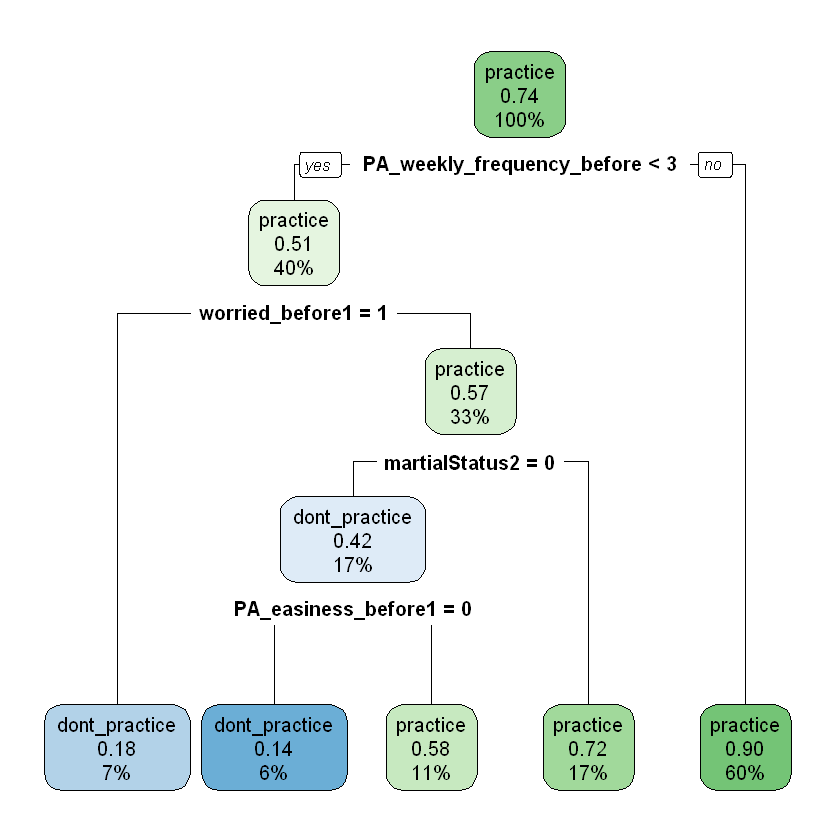

In [8]:
set.seed(2)
model <- fit_model(
    model_method="rpart",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv"),
    train_data = treino,
    test_data=teste,
    yname="PA_practice_during",
    length = 3
)
print(model$matrix)
# print(model$result)
rpart.plot(model$result$finalModel)



### Decision Tree: Accuracy metric with augmentation

Confusion Matrix and Statistics

               Reference
Prediction      dont_practice practice
  dont_practice            16       28
  practice                 10       48
                                          
               Accuracy : 0.6275          
                 95% CI : (0.5261, 0.7212)
    No Information Rate : 0.7451          
    P-Value [Acc > NIR] : 0.99690         
                                          
                  Kappa : 0.2012          
                                          
 Mcnemar's Test P-Value : 0.00582         
                                          
            Sensitivity : 0.6154          
            Specificity : 0.6316          
         Pos Pred Value : 0.3636          
         Neg Pred Value : 0.8276          
             Prevalence : 0.2549          
         Detection Rate : 0.1569          
   Detection Prevalence : 0.4314          
      Balanced Accuracy : 0.6235          
                                          
       '

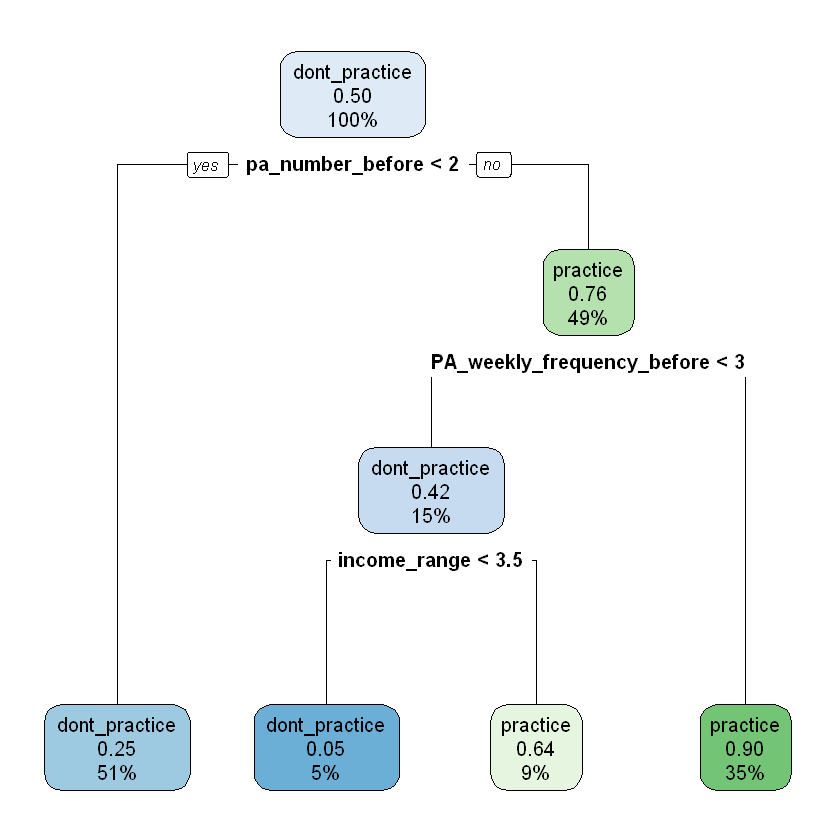

In [9]:
model <- fit_model(
    model_method="rpart",
    model_metric="Accuracy",
    trControl_func = trainControl(method = "cv"),
    train_data = treino.aug,
    test_data=teste,
    yname="PA_practice_during",
    length=3
)
print(model$matrix)
rpart.plot(model$result$finalModel)

### RF: Kappa metric without augmentation

In [10]:
set.seed(2)
model <- fit_model(
    model_method="rf",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv", search="grid"),
    train_data = treino,
    test_data=teste,
    yname="PA_practice_during",
    length = 15
)
print(model$matrix)

Confusion Matrix and Statistics

               Reference
Prediction      dont_practice practice
  dont_practice            14       12
  practice                 12       64
                                          
               Accuracy : 0.7647          
                 95% CI : (0.6704, 0.8431)
    No Information Rate : 0.7451          
    P-Value [Acc > NIR] : 0.373           
                                          
                  Kappa : 0.3806          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 0.5385          
            Specificity : 0.8421          
         Pos Pred Value : 0.5385          
         Neg Pred Value : 0.8421          
             Prevalence : 0.2549          
         Detection Rate : 0.1373          
   Detection Prevalence : 0.2549          
      Balanced Accuracy : 0.6903          
                                          
       '

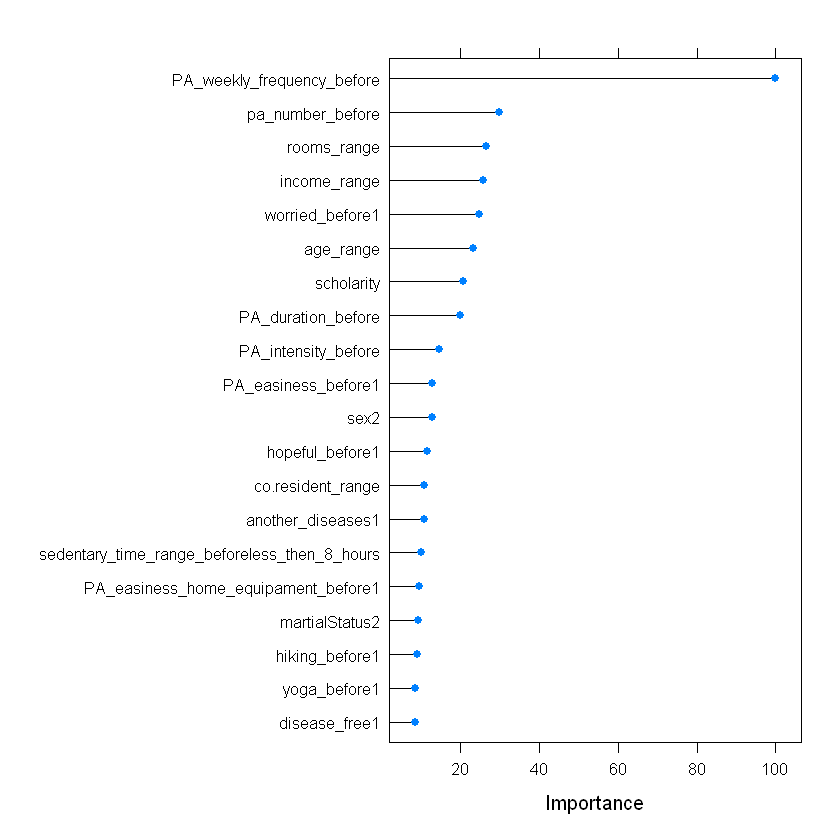

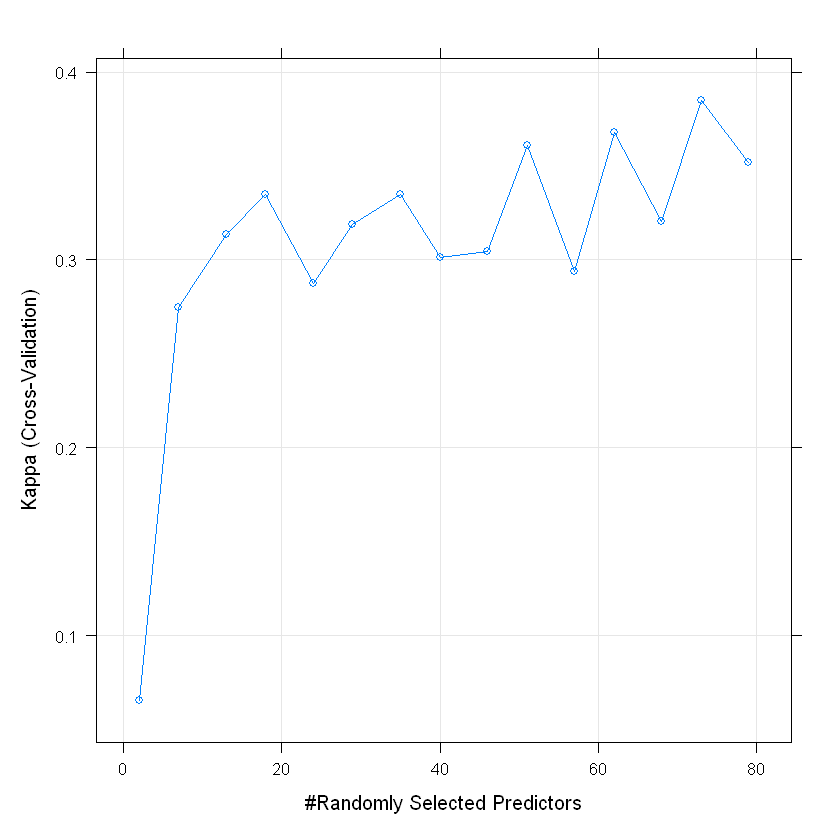

In [11]:
plot(varImp(model$result), top=20)
plot(model$result)


### RF: Accuracy metric with augmentation

In [12]:
set.seed(2)
model <- fit_model(
    model_method="rf",
    model_metric="Accuracy",
    trControl_func = trainControl(method = "cv", search="grid"),
    train_data = treino.aug,
    test_data=teste,
    yname="PA_practice_during",
    length = 15
)
print(model$matrix)

Confusion Matrix and Statistics

               Reference
Prediction      dont_practice practice
  dont_practice            12       11
  practice                 14       65
                                          
               Accuracy : 0.7549          
                 95% CI : (0.6598, 0.8347)
    No Information Rate : 0.7451          
    P-Value [Acc > NIR] : 0.4621          
                                          
                  Kappa : 0.3293          
                                          
 Mcnemar's Test P-Value : 0.6892          
                                          
            Sensitivity : 0.4615          
            Specificity : 0.8553          
         Pos Pred Value : 0.5217          
         Neg Pred Value : 0.8228          
             Prevalence : 0.2549          
         Detection Rate : 0.1176          
   Detection Prevalence : 0.2255          
      Balanced Accuracy : 0.6584          
                                          
       '

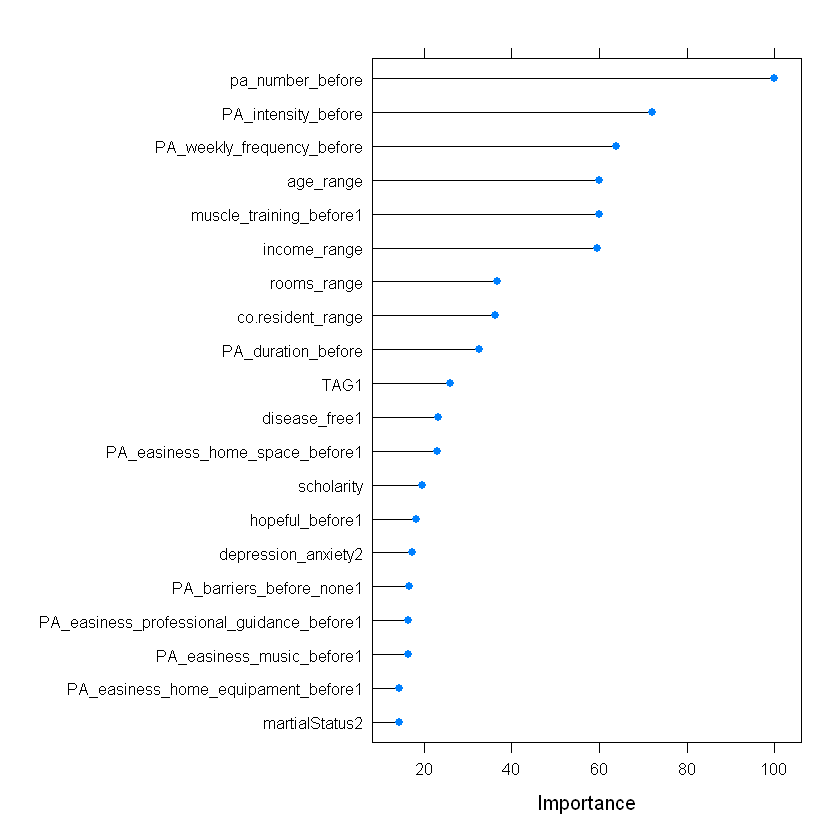

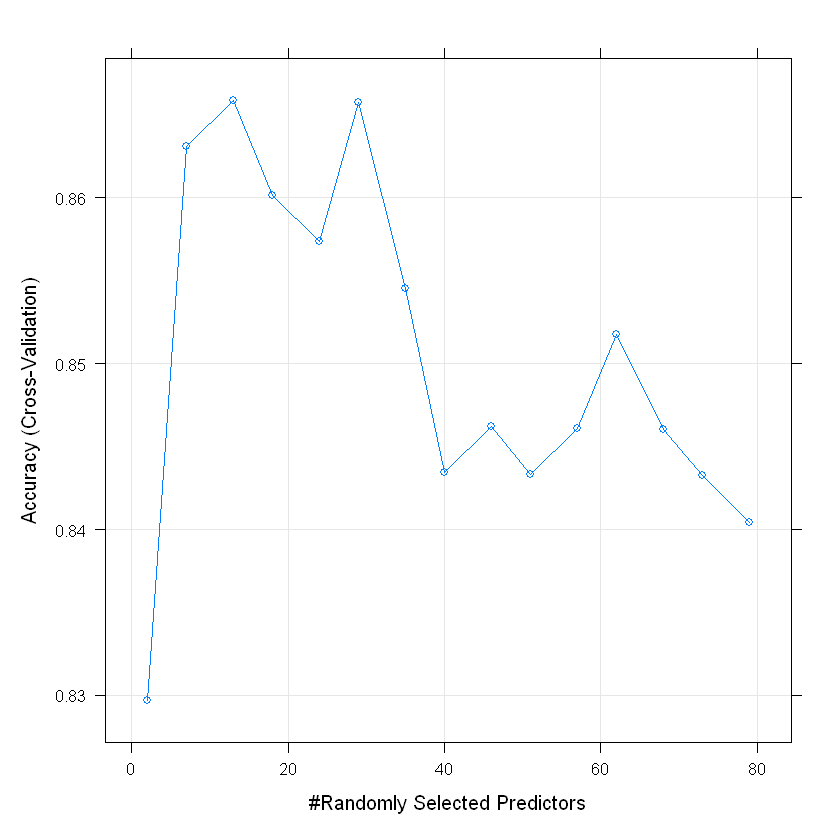

In [13]:
plot(varImp(model$result), top=20)
plot(model$result)


## Output variable: sedentary time range

In [14]:
table(sedentary_dataset[, "sedentary_time_range_during"])


   8_hour_or_more less_then_8_hours 
              111               233 

### Creating dataset partition

In [15]:
set.seed(2)
lista_treino <- createDataPartition(sedentary_dataset$sedentary_time_range_during, p=0.7, list=FALSE)
treino <- sedentary_dataset[lista_treino,]
teste <- sedentary_dataset[-lista_treino,]

### Applying augmentation into the training set

In [16]:
treino.aug <- data_augmentation(
    train_data=treino,
    yname="sedentary_time_range_during",
    maj_class = "less_then_8_hours",
    min_classes = c("8_hour_or_more"),
    ycol=match("sedentary_time_range_during",names(sedentary_dataset))
)

table(treino.aug[, "sedentary_time_range_during"])



   8_hour_or_more less_then_8_hours 
              164               164 

### Kappa metric without augmentation

Confusion Matrix and Statistics

                   Reference
Prediction          8_hour_or_more less_then_8_hours
  8_hour_or_more                12                 5
  less_then_8_hours             21                64
                                          
               Accuracy : 0.7451          
                 95% CI : (0.6492, 0.8262)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.082448        
                                          
                  Kappa : 0.3333          
                                          
 Mcnemar's Test P-Value : 0.003264        
                                          
            Sensitivity : 0.3636          
            Specificity : 0.9275          
         Pos Pred Value : 0.7059          
         Neg Pred Value : 0.7529          
             Prevalence : 0.3235          
         Detection Rate : 0.1176          
   Detection Prevalence : 0.1667          
      Balanced Accuracy : 0.6456          
     

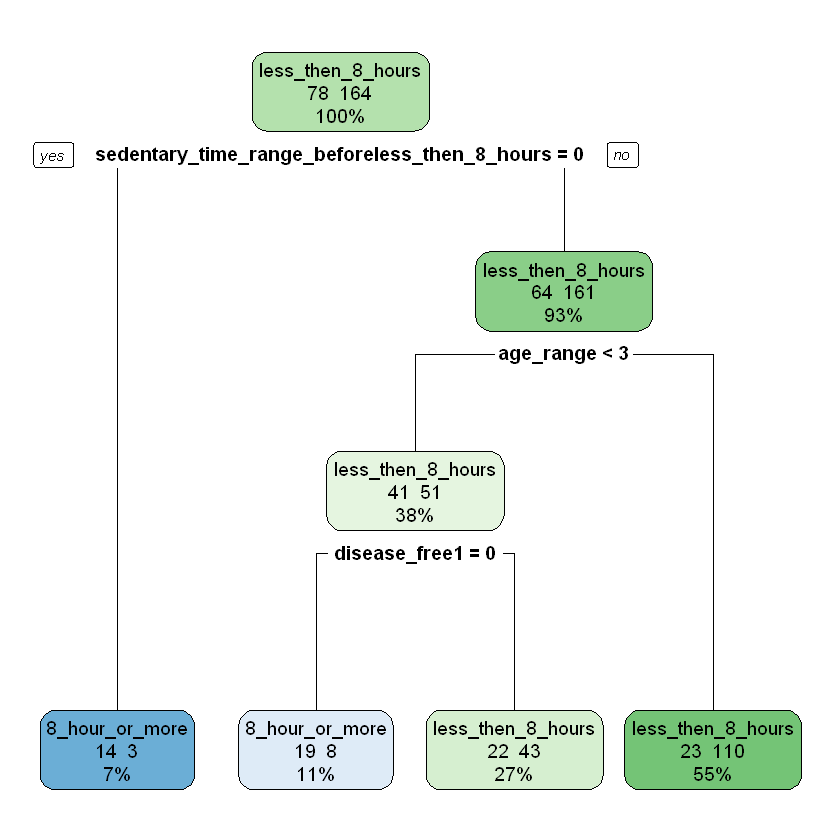

In [17]:
set.seed(2)
model <- fit_model(
    model_method="rpart",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv"),
    train_data = treino,
    test_data=teste,
    yname="sedentary_time_range_during",
    length = 3
)
print(model$matrix)
# print(model$result)
rpart.plot(model$result$finalModel, extra=101)



### Accuracy metric with augmentation

Confusion Matrix and Statistics

                   Reference
Prediction          8_hour_or_more less_then_8_hours
  8_hour_or_more                13                 5
  less_then_8_hours             20                64
                                          
               Accuracy : 0.7549          
                 95% CI : (0.6598, 0.8347)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.05370         
                                          
                  Kappa : 0.3647          
                                          
 Mcnemar's Test P-Value : 0.00511         
                                          
            Sensitivity : 0.3939          
            Specificity : 0.9275          
         Pos Pred Value : 0.7222          
         Neg Pred Value : 0.7619          
             Prevalence : 0.3235          
         Detection Rate : 0.1275          
   Detection Prevalence : 0.1765          
      Balanced Accuracy : 0.6607          
     

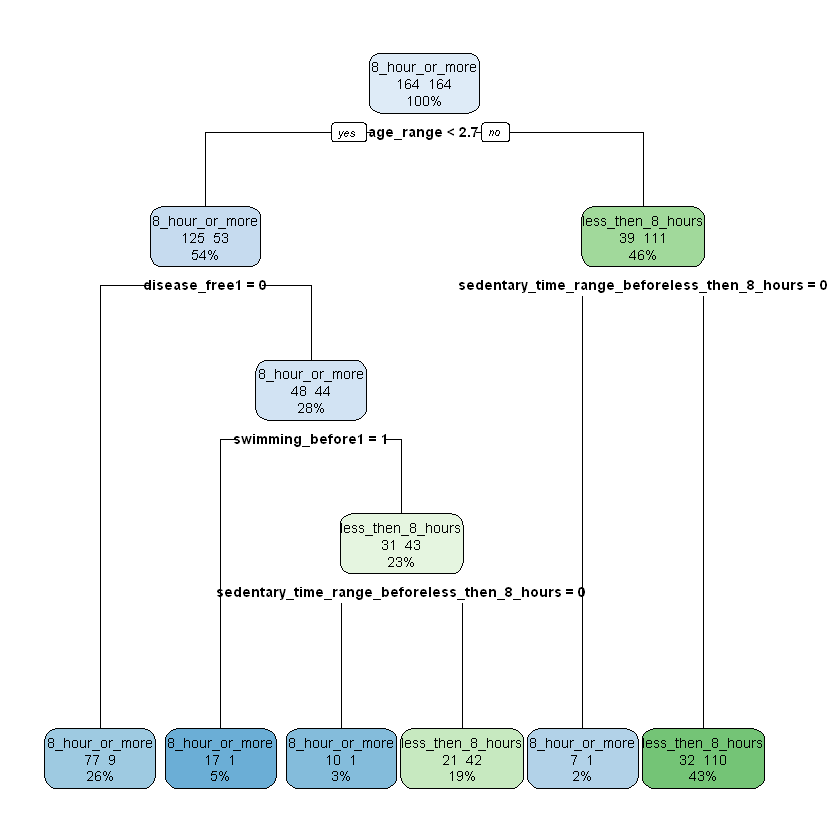

In [18]:
set.seed(2)
model <- fit_model(
    model_method="rpart",
    model_metric="Accuracy",
    trControl_func = trainControl(method = "cv"),
    train_data = treino.aug,
    test_data=teste,
    yname="sedentary_time_range_during",
    length = 3
)
print(model$matrix)
# print(model$result)
rpart.plot(model$result$finalModel, extra=101)



### RF: Kappa metric without augmentation

In [19]:
set.seed(2)
model <- fit_model(
    model_method="rf",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv", search="grid"),
    train_data = treino,
    test_data=teste,
    yname="sedentary_time_range_during",
    length = 15
)
print(model$matrix)

Confusion Matrix and Statistics

                   Reference
Prediction          8_hour_or_more less_then_8_hours
  8_hour_or_more                15                 5
  less_then_8_hours             18                64
                                          
               Accuracy : 0.7745          
                 95% CI : (0.6811, 0.8514)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.01981         
                                          
                  Kappa : 0.4258          
                                          
 Mcnemar's Test P-Value : 0.01234         
                                          
            Sensitivity : 0.4545          
            Specificity : 0.9275          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 0.7805          
             Prevalence : 0.3235          
         Detection Rate : 0.1471          
   Detection Prevalence : 0.1961          
      Balanced Accuracy : 0.6910          
     

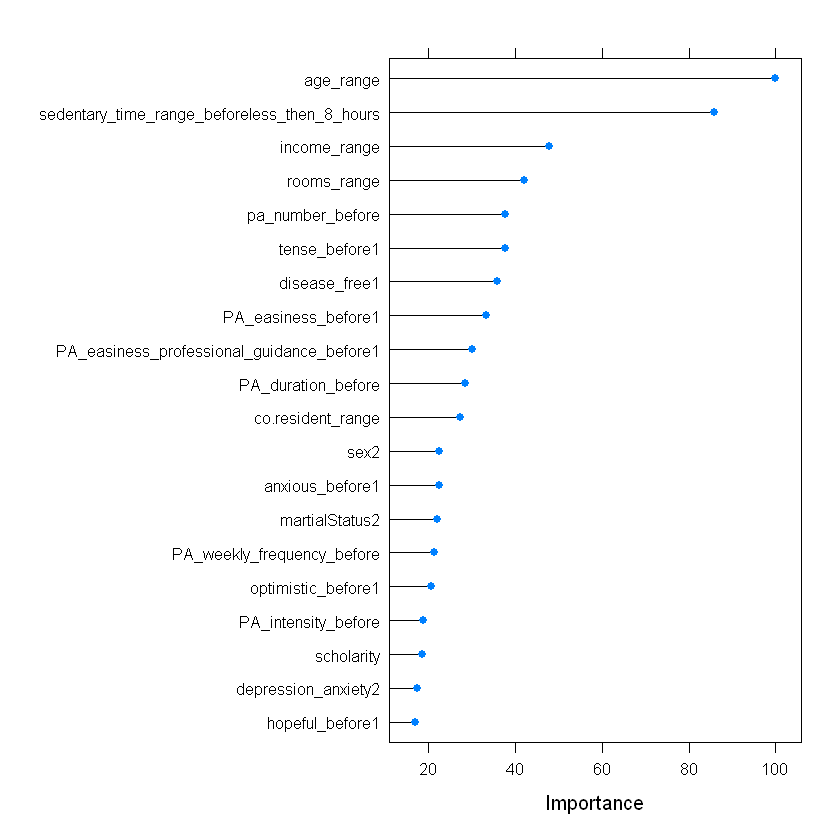

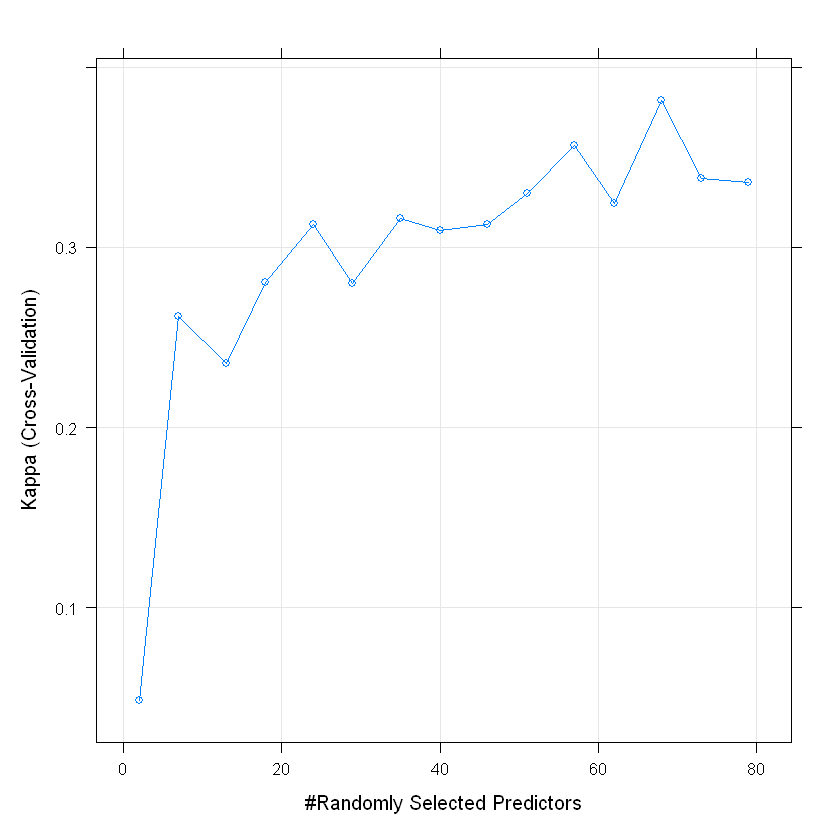

In [20]:
plot(varImp(model$result), top=20)
plot(model$result)


### RF: Accuracy metric with augmentation

In [21]:
set.seed(2)
model <- fit_model(
    model_method="rf",
    model_metric="Accuracy",
    trControl_func = trainControl(method = "cv", search="grid"),
    train_data = treino.aug,
    test_data=teste,
    yname="sedentary_time_range_during",
    length = 15
)
print(model$matrix)

Confusion Matrix and Statistics

                   Reference
Prediction          8_hour_or_more less_then_8_hours
  8_hour_or_more                12                 1
  less_then_8_hours             21                68
                                          
               Accuracy : 0.7843          
                 95% CI : (0.6919, 0.8596)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.01117         
                                          
                  Kappa : 0.4147          
                                          
 Mcnemar's Test P-Value : 5.104e-05       
                                          
            Sensitivity : 0.3636          
            Specificity : 0.9855          
         Pos Pred Value : 0.9231          
         Neg Pred Value : 0.7640          
             Prevalence : 0.3235          
         Detection Rate : 0.1176          
   Detection Prevalence : 0.1275          
      Balanced Accuracy : 0.6746          
     

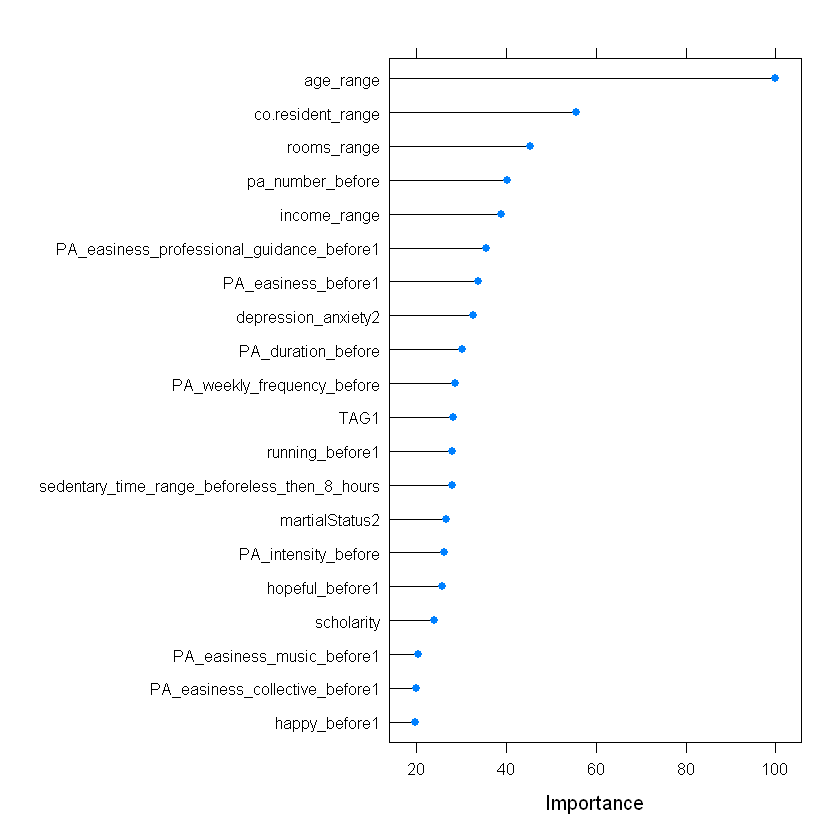

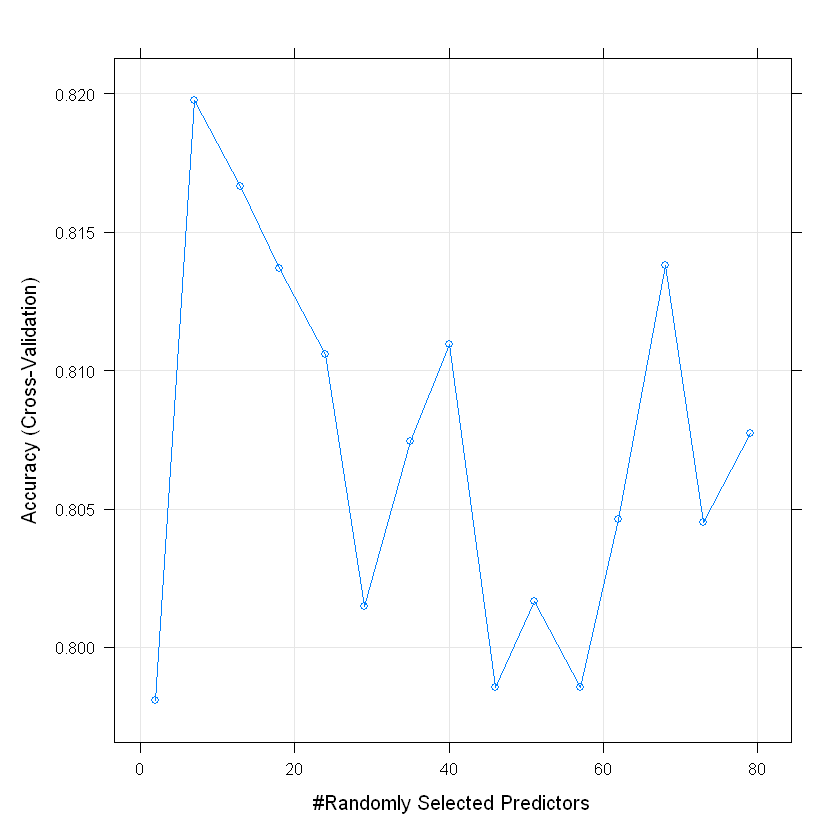

In [22]:
plot(varImp(model$result), top=20)
plot(model$result)


## Output variable: Practice of exercise behavior

In [23]:
dim(pa_behavior_dataset)

[1] 344  73

In [24]:
table(pa_behavior_dataset_1[, "pa_behavior"])


change_to_dont_practice          still_practice 
                     70                     234 

There is a majority class, we should apply data augmentation. We chose kappa metrict to optimize becouse data is unbalanced.

### Creating the dataset partition: practice before

In [25]:
set.seed(2)
lista_treino <- createDataPartition(pa_behavior_dataset_1$pa_behavior, p=0.7, list=FALSE)
treino <- pa_behavior_dataset_1[lista_treino,]
teste <- pa_behavior_dataset_1[-lista_treino,]

### Applying augmentation into the training set: practice before

In [26]:
treino.aug <- data_augmentation(
    train_data=treino,
    yname="pa_behavior",
    maj_class = "still_practice",
    min_classes = c("change_to_dont_practice"),
    ycol=match("pa_behavior",names(pa_behavior_dataset_1))
)

table(treino.aug[, "pa_behavior"])



change_to_dont_practice          still_practice 
                    164                     164 

### Kappa metric without augmentation: practice before

Confusion Matrix and Statistics

                         Reference
Prediction                change_to_dont_practice still_practice
  change_to_dont_practice                       7              4
  still_practice                               14             66
                                                 
               Accuracy : 0.8022                 
                 95% CI : (0.7055, 0.8784)       
    No Information Rate : 0.7692                 
    P-Value [Acc > NIR] : 0.27167                
                                                 
                  Kappa : 0.3314                 
                                                 
 Mcnemar's Test P-Value : 0.03389                
                                                 
            Sensitivity : 0.33333                
            Specificity : 0.94286                
         Pos Pred Value : 0.63636                
         Neg Pred Value : 0.82500                
             Prevalence : 0.23077    

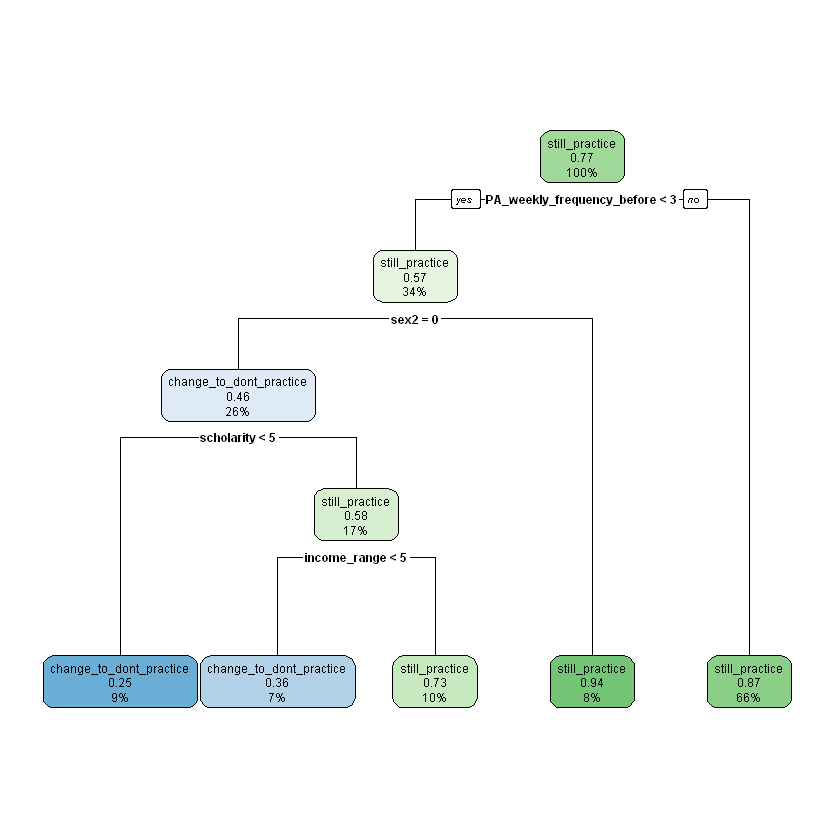

In [27]:
set.seed(2)
model <- fit_model(
    model_method="rpart",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv"),
    train_data = treino,
    test_data=teste,
    yname="pa_behavior",
    length = 3
)
print(model$matrix)
# print(model$result)
rpart.plot(model$result$finalModel)



### Accuracy metric with augmentation: practice before

Confusion Matrix and Statistics

                         Reference
Prediction                change_to_dont_practice still_practice
  change_to_dont_practice                      11             18
  still_practice                               10             52
                                                 
               Accuracy : 0.6923                 
                 95% CI : (0.5868, 0.7849)       
    No Information Rate : 0.7692                 
    P-Value [Acc > NIR] : 0.9656                 
                                                 
                  Kappa : 0.2353                 
                                                 
 Mcnemar's Test P-Value : 0.1859                 
                                                 
            Sensitivity : 0.5238                 
            Specificity : 0.7429                 
         Pos Pred Value : 0.3793                 
         Neg Pred Value : 0.8387                 
             Prevalence : 0.2308     

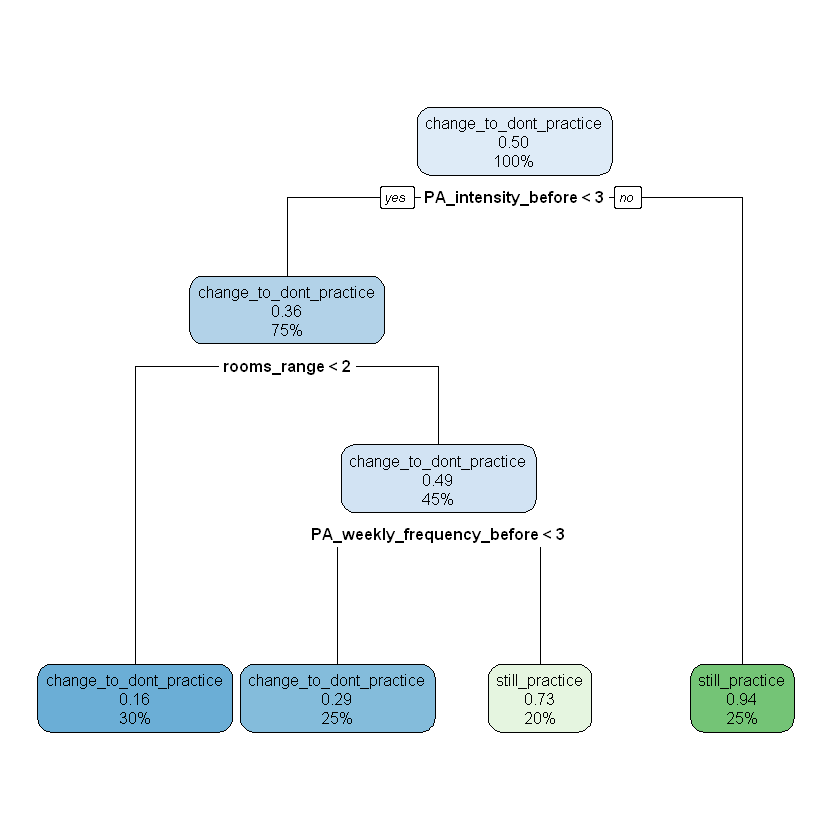

In [28]:
model <- fit_model(
    model_method="rpart",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv"),
    train_data = treino.aug,
    test_data=teste,
    yname="pa_behavior",
    length=3
)
print(model$matrix)
rpart.plot(model$result$finalModel)

### RF practice before: Kappa metric without augmentation

In [29]:
set.seed(2)
model <- fit_model(
    model_method="rf",
    model_metric="Kappa",
    trControl_func = trainControl(method = "cv", search="grid"),
    train_data = treino,
    test_data=teste,
    yname="pa_behavior",
    length = 15
)
print(model$matrix)

Confusion Matrix and Statistics

                         Reference
Prediction                change_to_dont_practice still_practice
  change_to_dont_practice                       7              5
  still_practice                               14             65
                                                 
               Accuracy : 0.7912                 
                 95% CI : (0.6933, 0.8694)       
    No Information Rate : 0.7692                 
    P-Value [Acc > NIR] : 0.36190                
                                                 
                  Kappa : 0.3081                 
                                                 
 Mcnemar's Test P-Value : 0.06646                
                                                 
            Sensitivity : 0.33333                
            Specificity : 0.92857                
         Pos Pred Value : 0.58333                
         Neg Pred Value : 0.82278                
             Prevalence : 0.23077    

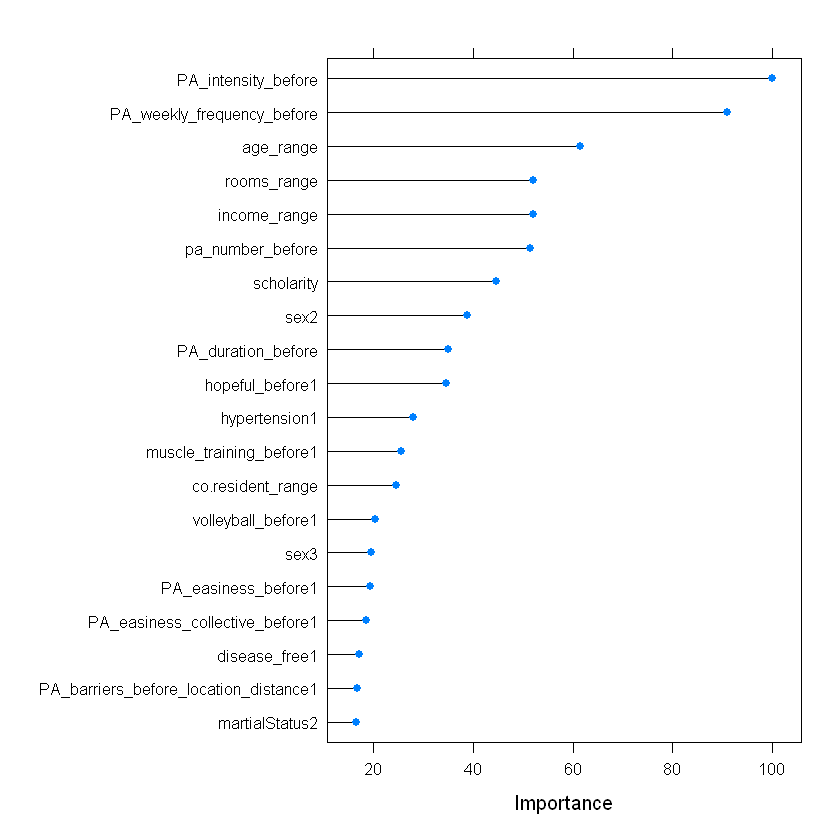

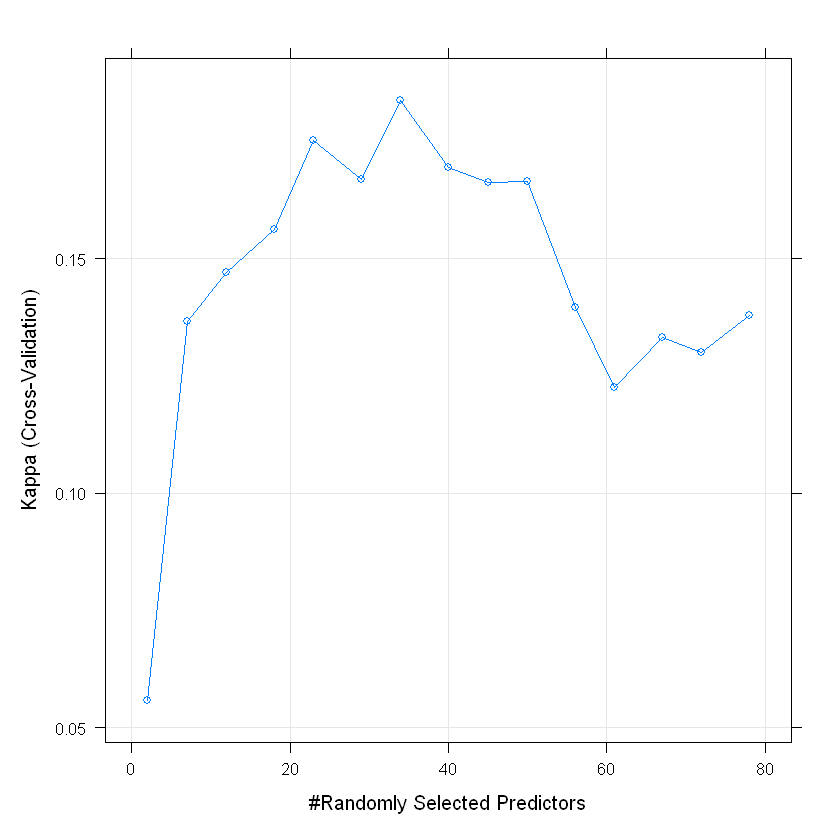

In [30]:
plot(varImp(model$result), top=20)
plot(model$result)


### RF practice before: Accuracy metric with augmentation

In [31]:
set.seed(2)
model <- fit_model(
    model_method="rf",
    model_metric="Accuracy",
    trControl_func = trainControl(method = "cv", search="grid"),
    train_data = treino.aug,
    test_data=teste,
    yname="pa_behavior",
    length = 15
)
print(model$matrix)

Confusion Matrix and Statistics

                         Reference
Prediction                change_to_dont_practice still_practice
  change_to_dont_practice                       7              4
  still_practice                               14             66
                                                 
               Accuracy : 0.8022                 
                 95% CI : (0.7055, 0.8784)       
    No Information Rate : 0.7692                 
    P-Value [Acc > NIR] : 0.27167                
                                                 
                  Kappa : 0.3314                 
                                                 
 Mcnemar's Test P-Value : 0.03389                
                                                 
            Sensitivity : 0.33333                
            Specificity : 0.94286                
         Pos Pred Value : 0.63636                
         Neg Pred Value : 0.82500                
             Prevalence : 0.23077    

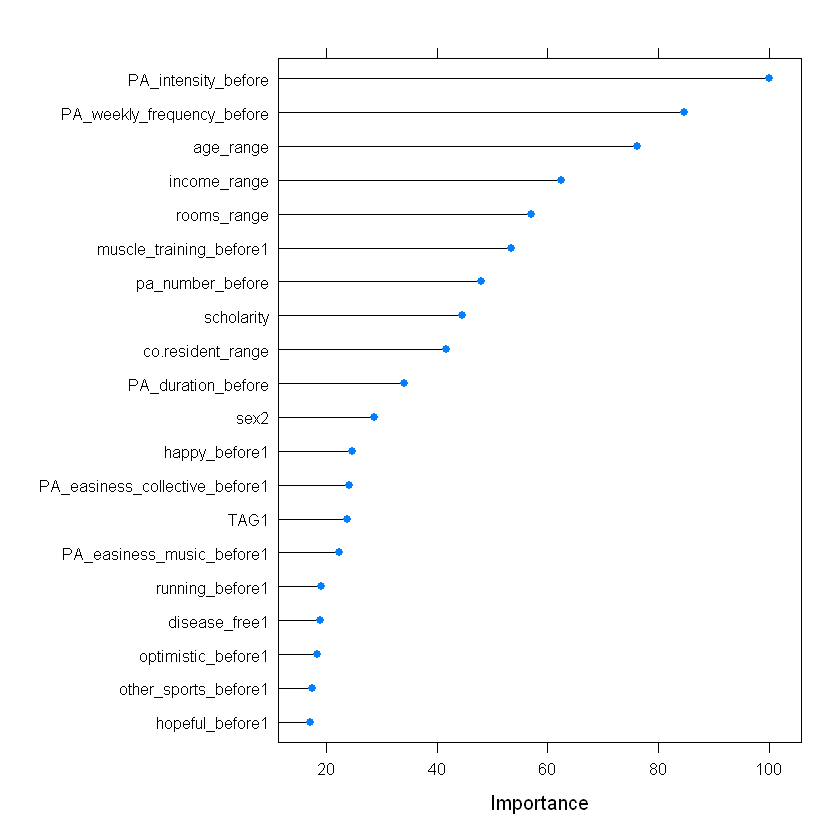

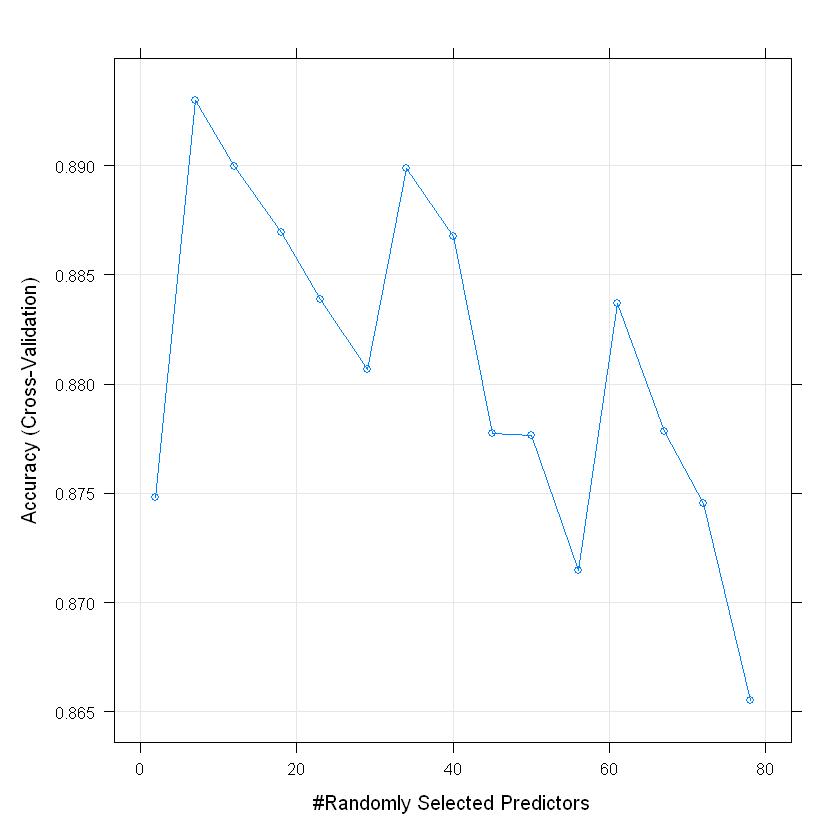

In [32]:
plot(varImp(model$result), top=20)
plot(model$result)
